# AIN313 - Machine Learning Lab.

**Assignment 1**

**Diesase Detection on X-Ray Images**

**Instructor: **Erkut Erdem

**TA:** Sibel Kapan


## Student Information

Please fill the informations!

Name Surname: Alihan Sağöz

Student ID: 21993035

In [ ]:
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from random import shuffle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def imshow(title="Image", image=None, size=8): #for showing images 
  w, h = image.shape[0], image.shape[1]
  aspect_ratio = w / h
  plt.figure(figsize=(size * aspect_ratio, size))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title(title)
  plt.show()

# *Problem:*

We have a dataset of 3000 X-Ray images, and we know which diseases they belong to. What we need to do is to use the model we trained with this data set of 3000 thousand data to make it possible to predict which disease the images it has never seen belong to.

# *Solution:*

We extract the different features of 3000 thousand xray photos that we read and classify from the folder, using shape and texture filters, and turn these photos into black and white, and after combining the array as much as 32x32 features, we put them on our train set.


We are writing 3 different filter methods that we want, I chose Noise Removing, Canny and Gabor filters here.

Then we create a function called image_process and this function decides which features to extract and add to the array using the parameters we give.


In [ ]:
def image_process(img = None, Canny = True , Gabor = True , Noise = True): #takes image and returning array that consist of filtered photos
  img = cv2.resize(img,(img_size,img_size))
  features = []
  imgNoise = denoise(img)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  cannyimage = canny(img)
  gaborimage = gabor(img)
  if(Canny):
    features.append(cannyimage)
  if(Gabor):
    features.append(gaborimage)
  if(Noise):
    features.append(imgNoise)
  return features

def denoise(img = None): #noise removing
  img = cv2.fastNlMeansDenoisingColored(img, None, 1, 1, 1, 1)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

def canny(img = None):
  edges = cv2.Canny(img,50,135)
  return edges

def gabor(img = None):
  g_kernel = cv2.getGaborKernel((30, 30), 4.0, np.pi/16, 10.0, 0.5, 0, ktype=cv2.CV_32F)
  g_kernel /=1.5*g_kernel.sum()
  filtered_img = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)
  return filtered_img

We are pulling our data from the train file in our dataset in google drive to colab. While taking, we adjust the size of our photos and specify which class it belongs to. We start preparing our train array. The reason why we don't do the filtering here is that we want to perform these operations on our relatively small array of 32x32 photos that we have created, instead of reading the data from the drive again and again every time we want to try a new filter.

In [ ]:
def load_covid_normal_pnueumonia(number = None): #for loading training data from directory to here.
  X,Y=[],[]
  z=[]
  for cata in tqdm(os.listdir(r'drive/MyDrive/chest_xray/train')):
    path_main=os.path.join(r'drive/MyDrive/chest_xray/train',cata)
    if quality[0] in cata:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,0])
    elif quality[1] in cata:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,1])
    else:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,2])

  print('Shuffling your data.....')
  shuffle(z)
  if number!=None:
    z = random.sample(z, number)
  for images, labels in tqdm(z):
    X.append(images);Y.append(labels)
  return X,Y

Here we do the same thing we did for the train file above for the test file and we start preparing our test array.

In [ ]:
def load_test_covid_normal_pnueumonia(number = None): #for loading test data from directory to here.
  X,Y=[],[]
  z=[]
  for cata in tqdm(os.listdir(r'drive/MyDrive/chest_xray/test')):
    path_main=os.path.join(r'drive/MyDrive/chest_xray/test',cata)
    if quality[0] in cata:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,0])
    elif quality[1] in cata:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,1])
    else:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,2])
  print('Shuffling your data.....')
  shuffle(z)
  if number!=None:
    z = random.sample(z, number)
  for images, labels in tqdm(z):
    X.append(images);Y.append(labels)
  return X,Y

In [ ]:
img_size = 32 #img size
thickness_value = 1 #thicknes_value for contour finding
quality=['covid', 'normal','pneumonia'] 


Loading the train data to X and Y array variables.


In [ ]:
X, Y = load_covid_normal_pnueumonia() 

100%|██████████| 3/3 [01:07<00:00, 22.50s/it]


Shuffling your data.....


100%|██████████| 3000/3000 [00:00<00:00, 759654.19it/s]


In [ ]:
sizeTrain = len(X)
sizeTrain

3000

Loading the test data to X_t and Y_t array variables.

In [ ]:
X_t, Y_t = load_test_covid_normal_pnueumonia()

100%|██████████| 3/3 [00:09<00:00,  3.23s/it]


Shuffling your data.....


100%|██████████| 300/300 [00:00<00:00, 567820.94it/s]


Here, we try the gabor canny and Noise removing filters we created for the image_process function above.

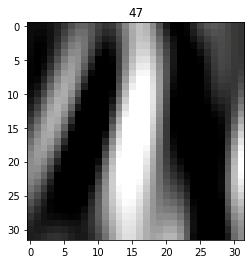

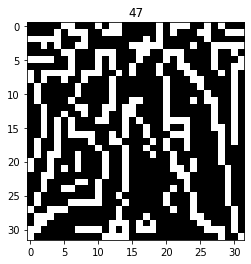

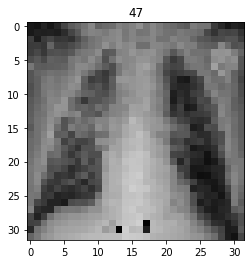

In [ ]:
imshow("47",gabor(X_t[3]),size = 4)
imshow("47",canny(X_t[3]),size = 4)
imshow("47",denoise(X_t[3]),size = 4)

Here, we are creating a dataframe to use to show the calculation of Accuracy, precision and recall values ​​that we will do with different variations in the future.

In [ ]:
data = {'Train Size':[],
        'Size': [],
        'Weighted':  [],
        'K value': [],
        'Canny': [],
        'Gabor': [],
        'NoiseRemoving': [],
        'Accuracy': [],
        'Precision':[],
        'Recall':[]
        }
df = pd.DataFrame(data)


Here we create our class that we will use for both Weighted KNN and normal KNN. It includes functions for adding the train set to our class, estimating our test data, finding the nearest neighbors and their distances.

In [ ]:
class K_Nearest_Neighbors_Classifier() :  

  def __init__( self, K ) :    #initalize the class
    self.K = K

  def fit( self, X_train, Y_train ) : #fits the train data to class

    self.X_train = X_train      
    self.Y_train = Y_train
    self.m, self.n = X_train.shape     

  def predict( self, X_test, Weighted = False) : #predicts according to train data and variable that if that weighted or not.
    self.X_test = X_test
    self.Weighted = Weighted
    self.m_test, self.n = X_test.shape
    Y_predict = np.zeros( self.m_test )

    for i in range( self.m_test ) :
      x = self.X_test[i]
      neighbors = np.zeros( self.K )
      distances , neighbors = self.find_neighbors( x ) #finding neighbors and returns two sized array neighbors class and distances.
      if self.Weighted == False :
        Y_predict[i] = mode( neighbors )[0][0]     #if weighted is false returns mod class of neighbors
      else: #if weighted is true 
        freq1 = 0 # weighted sum of group 0 
        freq2 = 0 # weighted sum of group 1 
        freq3 = 0 # weighted sum of group 1 
        for d in range(len(neighbors)): #takes neighbors distance and calculates their weights according to weighted knn algorithm 
          distance = distances[0] 
          if neighbors[d] == 0:
            freq1 += (1 / distance)
          elif neighbors[d] == 1:
            freq2 += (1 / distance)
          elif neighbors[d] == 2:
            freq3 += (1 / distance)
          weight = freq1 + freq2 + freq3
          freq1 = freq1/weight
          freq2 = freq2/weight
          freq3 = freq3/weight
          if max([freq1, freq2, freq3]) == freq1: #if weighted sum of group 0 equals the maximum of all weighted sums.
            Y_predict[i] = 0    #returns 0
          elif max([freq1, freq2, freq3]) == freq2: #if weighted sum of group 1 equals the maximum of all weighted sums.
            Y_predict[i] = 1    #returns 1
          elif max([freq1, freq2, freq3]) == freq3: #if weighted sum of group 2 equals the maximum of all weighted sums.
            Y_predict[i] = 2    #returns 2
    return Y_predict
                  
  def find_neighbors( self, x ) : #finds all neighbors and distances and sorts them. according to k value of knn takes the first k neighbors and returns distances, and their class

    euclidean_distances = np.zeros( self.m )  
    for i in range( self.m ) :
      d = self.euclidean( x, self.X_train[i] )
      euclidean_distances[i] = d

    inds = euclidean_distances.argsort()
    distances = sorted(euclidean_distances[:self.K])
    Y_train_sorted = self.Y_train[inds]
    return distances , Y_train_sorted[:self.K]
      
              
  def euclidean( self, x, x_train ) : #euclidean distance formula
    return np.sqrt( np.sum( np.square( x - x_train ) ) )
        

Here we create a function to run the KNN function with the parameters we want from the shortcut. We write which filters we want to use, whether it is Weighted and which K (number of neighbors) values ​​it will work with. As a result, it adds the Accuracy, precision, and Recall values ​​to the table we created above. It helps a lot to compare performance.

In [ ]:
def knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False):
  x1 = []  
  xt = []
  for img in X:
    x1.append(image_process(img = img, Canny = Cannyx , Gabor = Gaborx , Noise = Noisex))
  for img in X_t:
    xt.append(image_process(img = img, Canny = Cannyx , Gabor = Gaborx , Noise = Noisex))

  X_train = np.array(x1) #array to np array
  Y_train = np.array(Y)
  X_test = np.array(xt)
  Y_test = np.array(Y_t)
  le = LabelEncoder()
  Y_train = le.fit_transform(Y_train) #transforms np array to correct version for knn algorithm.
  Y_test = le.fit_transform(Y_test)

  X_train_size = X_train.shape[0]
  X_train = X_train.reshape(X_train_size,-1)
  X_test_size = X_test.shape[0]
  X_test = X_test.reshape(X_test_size,-1)

  model = K_Nearest_Neighbors_Classifier( K = k)   #knn model with k = 3

  model.fit( X_train, Y_train ) #fits the data to knn model
  Y_pred = model.predict( X_test , Weighted = weightedx ) #pred data for knn model
  acc = accuracy_score(Y_test, Y_pred)
  prec = precision_score(Y_test, Y_pred, average='macro')
  recall = recall_score(Y_test, Y_pred, average = 'macro')
  df.loc[len(df.index)] = [sizeTrain,img_size, weightedx, k, Cannyx, Gaborx, Noisex, acc, prec, recall] 


First of all, we use all filters. We run it in 2 different ways to see if weighted or normal works better with the number with 3 neighbors.

In [ ]:
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False) #weighted vs normal
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True)


In [ ]:
df

,Train Size,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,3000.0,32.0,0.0,3.0,1.0,1.0,1.0,0.806667,0.818192,0.806667
1,3000.0,32.0,True,3.0,True,True,True,0.793333,0.808203,0.793333


We determined that normal Knn is working better than weighted.

Now we run our function with different combinations of filters to see which filters work better using normal knn with 3 neighbors.


In [ ]:
knnFunc(k = 3, Cannyx = True, Gaborx = False, Noisex = True , weightedx = False) #best option
knnFunc(k = 3, Cannyx = False, Gaborx = True, Noisex = True , weightedx = False)
knnFunc(k = 3, Cannyx = False, Gaborx = False, Noisex = True , weightedx = False)


In [ ]:
df 

,Train Size,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,3000.0,32.0,0.0,3.0,1.0,1.0,1.0,0.806667,0.818192,0.806667
1,3000.0,32.0,True,3.0,True,True,True,0.793333,0.808203,0.793333
2,3000.0,32.0,False,3.0,True,False,True,0.746667,0.789886,0.746667
3,3000.0,32.0,False,3.0,False,True,True,0.806667,0.818192,0.806667
4,3000.0,32.0,False,3.0,False,False,True,0.750000,0.796381,0.750000


We determined that canny :true, gabor : true, noise :true gives best accuracy in this case 

Now we run our function with 5, 7 and 9 neighbor values ​​to see which number of neighbors works best.

In [ ]:
knnFunc(k = 5, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False) # best k
knnFunc(k = 7, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False)
knnFunc(k = 9, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False)


In [ ]:
knnFunc(k = 5, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True) # best k
knnFunc(k = 7, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True)
knnFunc(k = 9, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True)


In [ ]:
df

,Train Size,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,3000.0,32.0,0.0,3.0,1.0,1.0,1.0,0.806667,0.818192,0.806667
1,3000.0,32.0,True,3.0,True,True,True,0.793333,0.808203,0.793333
2,3000.0,32.0,False,3.0,True,False,True,0.746667,0.789886,0.746667
3,3000.0,32.0,False,3.0,False,True,True,0.806667,0.818192,0.806667
4,3000.0,32.0,False,3.0,False,False,True,0.750000,0.796381,0.750000
5,3000.0,32.0,False,5.0,True,True,True,0.806667,0.817023,0.806667
6,3000.0,32.0,False,7.0,True,True,True,0.800000,0.810581,0.800000
7,3000.0,32.0,False,9.0,True,True,True,0.803333,0.814419,0.803333
8,3000.0,32.0,True,5.0,True,True,True,0.793333,0.808203,0.793333
9,3000.0,32.0,True,7.0,True,True,True,0.793333,0.808203,0.793333


 in this case k=3 is working just fine

Now we will operate with 64x64 with the best options we find upstairs. Again, we will do the operations in order as we did above.

In [ ]:
img_size = 64


In [ ]:
X, Y = load_covid_normal_pnueumonia() 


100%|██████████| 3/3 [01:01<00:00, 20.66s/it]


Shuffling your data.....


100%|██████████| 3000/3000 [00:00<00:00, 537432.71it/s]


In [ ]:
X_t, Y_t = load_test_covid_normal_pnueumonia()

100%|██████████| 3/3 [00:09<00:00,  3.07s/it]


Shuffling your data.....


100%|██████████| 300/300 [00:00<00:00, 586889.55it/s]


we are doing the image_process part.

In [ ]:
x1 = []
xt = []
for img in X:
  x1.append(image_process(img = img, Canny = True , Gabor = True , Noise = True))
for img in X_t:
  xt.append(image_process(img = img, Canny = True , Gabor = True , Noise = True))

we are transforming our python array to numpy array.

In [ ]:
X_train = np.array(x1) #array to np array
Y_train = np.array(Y)
X_test = np.array(xt)
Y_test = np.array(Y_t)

Using the label encoder, we convert the variables in the Y_train Y_test to 0, 1 and 2 to classify. We are reshaping our X_train and X_Test for fitting knn algorithm

In [ ]:
le = LabelEncoder()
Y_train = le.fit_transform(Y_train) #transforms np array values their labelled version for knn algorithm.
Y_test = le.fit_transform(Y_test)

X_train_size = X_train.shape[0]
X_train = X_train.reshape(X_train_size,-1)
X_test_size = X_test.shape[0]
X_test = X_test.reshape(X_test_size,-1)

In [ ]:
print(X_train.shape)
X_train

(3000, 12288)


array([[  0, 255,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 255, 255, ...,   8,   0,   0],
       [  0,   0,   0, ...,  49,  16,  21],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

We place the X_train and Y_train files we prepared into our model. Then we put the X_test file we want to predict into the prediction function and we predict and create a Y_pred file.

In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
model = K_Nearest_Neighbors_Classifier( K = 3)   #knn model with k = 3
model.fit( X_train, Y_train ) #fits the data to knn model
Y_pred = model.predict( X_test , Weighted = False ) #pred data for knn model


We are preparing the confusion matrix

In [ ]:
cm = metrics.confusion_matrix(Y_test,Y_pred)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = quality, 
                     columns = quality)

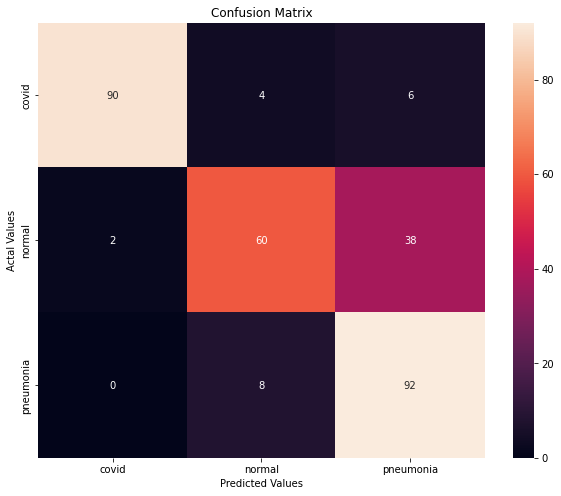

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In this matrix we can say that our model is close to predict that the normal patient as pneumonia.The rest of the predicts worked just fine

In [ ]:
print(metrics.classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       100
           1       0.83      0.60      0.70       100
           2       0.68      0.92      0.78       100

    accuracy                           0.81       300
   macro avg       0.83      0.81      0.80       300
weighted avg       0.83      0.81      0.80       300



In [ ]:
acc = accuracy_score(Y_test, Y_pred)
prec = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average = 'macro')
df.loc[len(df.index)] = [sizeTrain , img_size, False, 3, True, True, True, acc, prec, recall] 
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True) #weighted vs normal

In [ ]:
df

,Train Size,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,3000.0,32.0,0.0,3.0,1.0,1.0,1.0,0.806667,0.818192,0.806667
1,3000.0,32.0,True,3.0,True,True,True,0.793333,0.808203,0.793333
2,3000.0,32.0,False,3.0,True,False,True,0.746667,0.789886,0.746667
3,3000.0,32.0,False,3.0,False,True,True,0.806667,0.818192,0.806667
4,3000.0,32.0,False,3.0,False,False,True,0.750000,0.796381,0.750000
5,3000.0,32.0,False,5.0,True,True,True,0.806667,0.817023,0.806667
6,3000.0,32.0,False,7.0,True,True,True,0.800000,0.810581,0.800000
7,3000.0,32.0,False,9.0,True,True,True,0.803333,0.814419,0.803333
8,3000.0,32.0,True,5.0,True,True,True,0.793333,0.808203,0.793333
9,3000.0,32.0,True,7.0,True,True,True,0.793333,0.808203,0.793333


We got relatively better accuracy precision and recall values ​​with our 64 size photos.

In [ ]:
false_predicted = []
for i in range(len(Y_test)):
  if Y_test[i] != Y_pred[i]:
    false_predicted.append(i)

In [ ]:
print(false_predicted) #these are wrong predicted indexes lets take a few examples and look at [47,85,155]

[3, 6, 9, 15, 38, 41, 46, 48, 59, 77, 78, 80, 95, 99, 103, 105, 117, 118, 121, 123, 134, 142, 143, 146, 152, 155, 162, 173, 174, 179, 181, 182, 183, 184, 187, 189, 198, 204, 215, 219, 225, 234, 239, 242, 243, 244, 249, 254, 258, 259, 264, 265, 273, 282, 288, 289, 290, 292]


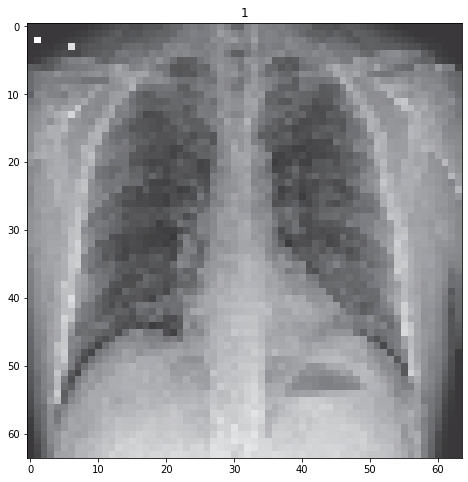

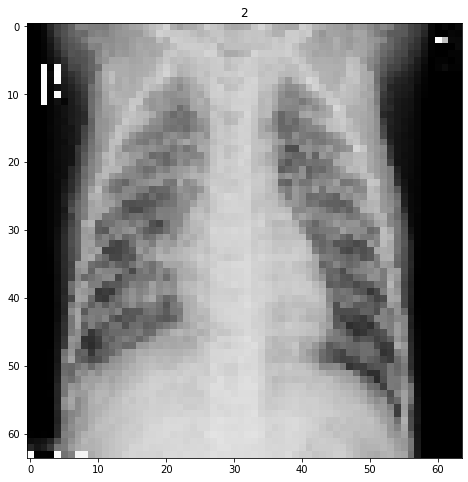

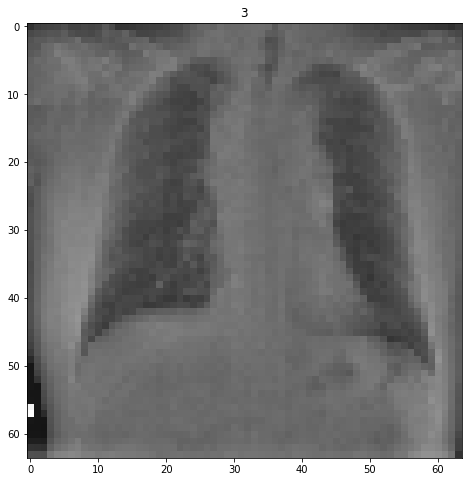

In [ ]:
imshow("1",X_t[random.randint(0,len(false_predicted))])
imshow("2",X_t[random.randint(0,len(false_predicted))])
imshow("3",X_t[random.randint(0,len(false_predicted))])

As you can see in photos there are certain black and whites that does not fit the rest of the foto. I can say that because of cables on the photos are breaking the photo thats why
our model fail to understand about what they are and thinks that all of them are relevant but it is not. As a solution we could use different methods that works better of computer vision or we can get rid of the cables one by one with manuel. 

We get different size of random samples from our train file.

In [ ]:
X, Y = load_covid_normal_pnueumonia(number = 1000)
sizeTrain = len(X)

100%|██████████| 3/3 [01:01<00:00, 20.53s/it]


Shuffling your data.....


100%|██████████| 1000/1000 [00:00<00:00, 491308.89it/s]


In [ ]:
X_t, Y_t = load_test_covid_normal_pnueumonia()

100%|██████████| 3/3 [00:12<00:00,  4.21s/it]


Shuffling your data.....


100%|██████████| 300/300 [00:00<00:00, 537501.58it/s]


In [ ]:
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True)

In [ ]:
df

,Train Size,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,3000.0,32.0,0.0,3.0,1.0,1.0,1.0,0.806667,0.818192,0.806667
1,3000.0,32.0,True,3.0,True,True,True,0.793333,0.808203,0.793333
2,3000.0,32.0,False,3.0,True,False,True,0.746667,0.789886,0.746667
3,3000.0,32.0,False,3.0,False,True,True,0.806667,0.818192,0.806667
4,3000.0,32.0,False,3.0,False,False,True,0.750000,0.796381,0.750000
5,3000.0,32.0,False,5.0,True,True,True,0.806667,0.817023,0.806667
6,3000.0,32.0,False,7.0,True,True,True,0.800000,0.810581,0.800000
7,3000.0,32.0,False,9.0,True,True,True,0.803333,0.814419,0.803333
8,3000.0,32.0,True,5.0,True,True,True,0.793333,0.808203,0.793333
9,3000.0,32.0,True,7.0,True,True,True,0.793333,0.808203,0.793333


In [ ]:
X, Y = load_covid_normal_pnueumonia(number = 500)
sizeTrain = len(X)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True)

100%|██████████| 3/3 [00:58<00:00, 19.58s/it]


Shuffling your data.....


100%|██████████| 500/500 [00:00<00:00, 618811.45it/s]


In [ ]:
df

,Train Size,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,3000.0,32.0,0.0,3.0,1.0,1.0,1.0,0.806667,0.818192,0.806667
1,3000.0,32.0,True,3.0,True,True,True,0.793333,0.808203,0.793333
2,3000.0,32.0,False,3.0,True,False,True,0.746667,0.789886,0.746667
3,3000.0,32.0,False,3.0,False,True,True,0.806667,0.818192,0.806667
4,3000.0,32.0,False,3.0,False,False,True,0.750000,0.796381,0.750000
5,3000.0,32.0,False,5.0,True,True,True,0.806667,0.817023,0.806667
6,3000.0,32.0,False,7.0,True,True,True,0.800000,0.810581,0.800000
7,3000.0,32.0,False,9.0,True,True,True,0.803333,0.814419,0.803333
8,3000.0,32.0,True,5.0,True,True,True,0.793333,0.808203,0.793333
9,3000.0,32.0,True,7.0,True,True,True,0.793333,0.808203,0.793333


In [ ]:
X, Y = load_covid_normal_pnueumonia(number = 250)
sizeTrain = len(X)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True)

100%|██████████| 3/3 [00:59<00:00, 20.00s/it]


Shuffling your data.....


100%|██████████| 250/250 [00:00<00:00, 678689.97it/s]


In [ ]:
df

,Train Size,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,3000.0,32.0,0.0,3.0,1.0,1.0,1.0,0.806667,0.818192,0.806667
1,3000.0,32.0,True,3.0,True,True,True,0.793333,0.808203,0.793333
2,3000.0,32.0,False,3.0,True,False,True,0.746667,0.789886,0.746667
3,3000.0,32.0,False,3.0,False,True,True,0.806667,0.818192,0.806667
4,3000.0,32.0,False,3.0,False,False,True,0.750000,0.796381,0.750000
5,3000.0,32.0,False,5.0,True,True,True,0.806667,0.817023,0.806667
6,3000.0,32.0,False,7.0,True,True,True,0.800000,0.810581,0.800000
7,3000.0,32.0,False,9.0,True,True,True,0.803333,0.814419,0.803333
8,3000.0,32.0,True,5.0,True,True,True,0.793333,0.808203,0.793333
9,3000.0,32.0,True,7.0,True,True,True,0.793333,0.808203,0.793333


In [ ]:
X, Y = load_covid_normal_pnueumonia(number = 100)
sizeTrain = len(X)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True)

100%|██████████| 3/3 [00:57<00:00, 19.33s/it]


Shuffling your data.....


100%|██████████| 100/100 [00:00<00:00, 327168.80it/s]


In [ ]:
df

,Train Size,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,3000.0,32.0,0.0,3.0,1.0,1.0,1.0,0.806667,0.818192,0.806667
1,3000.0,32.0,True,3.0,True,True,True,0.793333,0.808203,0.793333
2,3000.0,32.0,False,3.0,True,False,True,0.746667,0.789886,0.746667
3,3000.0,32.0,False,3.0,False,True,True,0.806667,0.818192,0.806667
4,3000.0,32.0,False,3.0,False,False,True,0.750000,0.796381,0.750000
5,3000.0,32.0,False,5.0,True,True,True,0.806667,0.817023,0.806667
6,3000.0,32.0,False,7.0,True,True,True,0.800000,0.810581,0.800000
7,3000.0,32.0,False,9.0,True,True,True,0.803333,0.814419,0.803333
8,3000.0,32.0,True,5.0,True,True,True,0.793333,0.808203,0.793333
9,3000.0,32.0,True,7.0,True,True,True,0.793333,0.808203,0.793333


In [ ]:
X, Y = load_covid_normal_pnueumonia(number = 10)
sizeTrain = len(X)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True)

100%|██████████| 3/3 [00:57<00:00, 19.14s/it]


Shuffling your data.....


100%|██████████| 10/10 [00:00<00:00, 24980.96it/s]


In [ ]:
df

,Train Size,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,3000.0,32.0,0.0,3.0,1.0,1.0,1.0,0.806667,0.818192,0.806667
1,3000.0,32.0,True,3.0,True,True,True,0.793333,0.808203,0.793333
2,3000.0,32.0,False,3.0,True,False,True,0.746667,0.789886,0.746667
3,3000.0,32.0,False,3.0,False,True,True,0.806667,0.818192,0.806667
4,3000.0,32.0,False,3.0,False,False,True,0.750000,0.796381,0.750000
5,3000.0,32.0,False,5.0,True,True,True,0.806667,0.817023,0.806667
6,3000.0,32.0,False,7.0,True,True,True,0.800000,0.810581,0.800000
7,3000.0,32.0,False,9.0,True,True,True,0.803333,0.814419,0.803333
8,3000.0,32.0,True,5.0,True,True,True,0.793333,0.808203,0.793333
9,3000.0,32.0,True,7.0,True,True,True,0.793333,0.808203,0.793333


In [ ]:
X, Y = load_covid_normal_pnueumonia(number = 7)
sizeTrain = len(X)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False)
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True)

100%|██████████| 3/3 [00:57<00:00, 19.02s/it]


Shuffling your data.....


100%|██████████| 7/7 [00:00<00:00, 35980.55it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df

,Train Size,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,3000.0,32.0,0.0,3.0,1.0,1.0,1.0,0.806667,0.818192,0.806667
1,3000.0,32.0,True,3.0,True,True,True,0.793333,0.808203,0.793333
2,3000.0,32.0,False,3.0,True,False,True,0.746667,0.789886,0.746667
3,3000.0,32.0,False,3.0,False,True,True,0.806667,0.818192,0.806667
4,3000.0,32.0,False,3.0,False,False,True,0.750000,0.796381,0.750000
5,3000.0,32.0,False,5.0,True,True,True,0.806667,0.817023,0.806667
6,3000.0,32.0,False,7.0,True,True,True,0.800000,0.810581,0.800000
7,3000.0,32.0,False,9.0,True,True,True,0.803333,0.814419,0.803333
8,3000.0,32.0,True,5.0,True,True,True,0.793333,0.808203,0.793333
9,3000.0,32.0,True,7.0,True,True,True,0.793333,0.808203,0.793333


As we can see, our values ​​continue to decrease as our train file gets smaller.

# *Conculusion:*
Although the model we used was not suitable for our purpose, it gave good enough results because it has only 3 classes. Different filters can be tried with different values ​​to improve the model. The variations are endless. With models using deep learning algorithms such as CNN, we can get much higher accuracy and much more accurate predictions.